In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Задание


Имеется [файл](https://yadi.sk/d/EPeQsxoS3L33a8) с различными оценками асессоров.

Формат файла: login tuid docid jud cjud.

Пояснение к формату: 
* login — логин асессора; 
* uid — id асессора (user id); 
* docid — id оцениваемого документа (document id); 
* jud — оценка асессора (judgement); 
* cjud — правильная оценка (correct judgement); 
* разделитель — табуляция \t.

Оценки могут принимать значение [0, 1], т.е. задание, которое сделали асессоры, имеет бинарную шкалу.

Используя данные об оценках, установите, какие асессоры хуже всего справились с заданием. На какие показатели вы ориентировались и какие метрики вы использовали для ответа на этот вопрос? Можно ли предложить какие-то новые метрики для подсчета качества асессоров с учетом природы оценок у этого бинарного задания?

Опишите подробно все этапы вашего решения.


## Загрузка данных

In [2]:
df_in = pd.read_csv('../../data/data_task3.csv', 
                    sep = '\t', 
#                     parse_dates = ['assigned_ts','closed_ts']
                   )
df_in['quality'] = (df_in['jud'] == df_in['cjud']).astype(int)
df_in

,login,uid,docid,jud,cjud,quality
0,assessor158,158,0,0,0,1
1,assessor238,238,0,0,0,1
2,assessor488,488,0,0,0,1
3,assessor136,136,0,0,0,1
4,assessor300,300,0,0,0,1
...,...,...,...,...,...,...
249995,assessor208,208,49999,1,1,1
249996,assessor139,139,49999,1,1,1
249997,assessor333,333,49999,1,1,1
249998,assessor160,160,49999,1,1,1


In [3]:
# Проверка пропусков в данных
df_in.isna().sum()

login      0
uid        0
docid      0
jud        0
cjud       0
quality    0
dtype: int64

In [4]:
# Распределение % значений в столбце правильных ответов
df_in['cjud'].value_counts() / df_in['cjud'].shape[0] * 100

0    88.008
1    11.992
Name: cjud, dtype: float64

## Матрица ответов асессоров

Из распределения значений в столбце 'cjud' мы видим явный дисбаланс в сторону значений "0"
Теперь строим матрицу ошибок для понимая их харрактера.

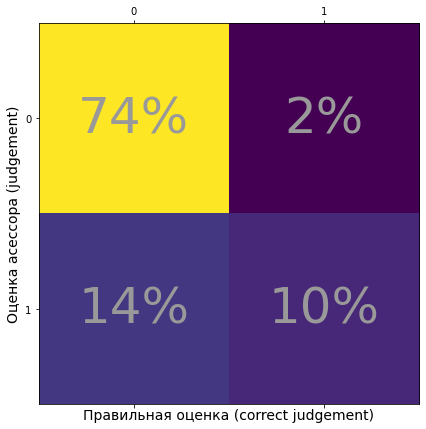

In [5]:
fig, ax = plt.subplots(figsize=(7,7))
df_matr = df_in[['jud', 'cjud']].value_counts().sort_index().unstack()
yticks = str(df_matr.index.name)
xticks = str(df_matr.columns.name)
# ax.set_xlabel(xticks)
# ax.set_ylabel(yticks)
ax.set_xlabel('Правильная оценка (correct judgement)',  fontsize=14)
ax.set_ylabel('Оценка асессора (judgement)',  fontsize=14)

im = ax.matshow(df_matr)
for i in range(len(df_matr.values)):
    for j in range(len(df_matr.values)):
        text = ax.text(j, i, str(round(df_matr.values[i, j] / df_in.shape[0] * 100)) + '%',
                       ha="center", va="center",size = 50, color=(.6,.6,.6))
plt.show()

Из данных явно видно что ценность успешного ответа на вопрос правильный ответ на который будет **1** ценнее нежени нежели те, где правильный ответ **0**

Для оценки ассоров в данном случае лучше всего подойдет метрика оценки **F1**

In [6]:
print('Количество уникальных пользователей: ', df_in.uid.unique().shape[0])

Количество уникальных пользователей:  600


## Рейтинг пользователе

Выводим 5 пользователей с лучшей оценкой и 5 с худшей

In [7]:
def assessors_rating(df):
    df_users = pd.DataFrame(index = df.uid.sort_values().unique())
    for uid in df_users.index:
        jud = df.loc[df['uid'] == uid, 'jud'] # Оценка ассесора
        cjud = df.loc[df['uid'] == uid, 'cjud'] # Верная оценка
        df_users.loc[uid, 'accuracy_score'] = accuracy_score(jud, cjud) # Простой процент правильных ответов
        df_users.loc[uid, 'f1_score'] = f1_score(jud, cjud) # f1 метрика полнота + качество
        df_users.loc[uid, 'Count'] = df.loc[df['uid'] == uid, 'uid'].count()
    #     break
    return df_users.sort_values('f1_score', ascending = False)
assessors_rating(df_in)

,accuracy_score,f1_score,Count
82,0.913151,0.751773,403.0
259,0.909976,0.751678,411.0
487,0.904535,0.750000,419.0
151,0.919048,0.742424,420.0
577,0.912530,0.741259,423.0
...,...,...,...
390,0.480583,0.207407,412.0
118,0.475703,0.189723,391.0
3,0.460094,0.178571,426.0
56,0.425791,0.163121,411.0


## Сложность заданий

Поскольку наша задача заключается в сравнительной оценке ассоров.
Для более точной оценки лучше исключить из выбрки те задания на которые все ассоры ответили верно или ошиблись.


<AxesSubplot:ylabel='Frequency'>

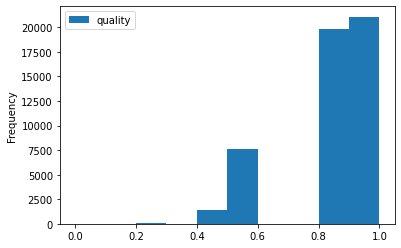

In [8]:
df_docid = df_in[['docid', 'quality']].groupby(['docid']).mean().sort_values('quality')
docid_list = df_docid[(df_docid['quality'] > 0)&(df_docid['quality'] < 1)].index
df_docid.plot.hist()

In [9]:
df_users = assessors_rating(df_in[df_in['docid'].isin(docid_list)])
df_users

,accuracy_score,f1_score,Count
487,0.824561,0.629630,228.0
596,0.839806,0.629213,206.0
171,0.846457,0.628571,254.0
184,0.854460,0.626506,213.0
259,0.839827,0.626263,231.0
...,...,...,...
3,0.276730,0.115385,318.0
56,0.276074,0.112782,326.0
111,0.676000,0.109890,250.0
118,0.325658,0.096916,304.0


In [10]:
# Проверка на наличие пропущщенных значений
df_users.isna().sum()

accuracy_score    0
f1_score          0
Count             0
dtype: int64